# Model Explainability
## Goals
1. Explain which features drive salary predictions (global explainability)
2. Explain individual predictions (local explainability)
3. Identify potential biases in model behavior


In [125]:
 # Imports
from pathlib import Path
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import shap
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import partial_dependence


In [44]:
# Constants
CLEANED_FILE_PATH: str = "../../data/cleaned/regression"
MODELS_SAVE_PATH: str = "../../models/regression"
FIGURES_SAVE_PATH: str = "../../figures"

In [45]:
# Load Data
output_dir = Path(CLEANED_FILE_PATH)

X_train = pl.read_csv(output_dir / "X_train_engineered.csv")
X_test = pl.read_csv(output_dir / "X_test_engineered.csv")
y_test_log = pl.read_csv(output_dir / "y_test_log.csv")["annual_salary_log"].to_numpy()
y_test_orig = pl.read_csv(output_dir / "y_test.csv")["annual_salary"].to_numpy()

# Load best model
best_model = joblib.load(Path(MODELS_SAVE_PATH) / "xgb_tuned.pkl")
feature_names = list(X_train.columns)

print("Data and model loaded successfully")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data and model loaded successfully
X_train shape: (15786, 54)
X_test shape: (3383, 54)


In [59]:
# Define feature groupings
feature_groups = {
    'Age': ['age_ordinal'],
    'Education': ['education_ordinal'],
    'Experience (Field)': ['experience_field_years_ordinal'],
    'Experience (Overall)': ['experience_overall_years_ordinal'],
    'Gender': [col for col in X_train.columns if col.startswith('gender_')],
    'Industry': [col for col in X_train.columns if col.startswith('industry_')],
    'Race': [col for col in X_train.columns if col.startswith('race_')],
    'Job Level': [col for col in X_train.columns if col.startswith('job_level_')],
    'Temporal': ['month', 'day_of_week', 'hour'],
    'Composite Features': ['experience_ratio', 'education_experience_interaction', 'experience_overall_sq'],
}

# Create mapping from feature index to group
feature_names = X_train.columns
feature_to_group = {}
for group_name, feature_list in feature_groups.items():
    for feature in feature_list:
        if feature in feature_names:
            idx = list(feature_names).index(feature)
            feature_to_group[idx] = group_name

print(f"Feature Groups Mapped:")
for group_name, features in feature_groups.items():
    valid_features = [f for f in features if f in feature_names]
    if valid_features:
        print(f"  {group_name:<30}: {len(valid_features)} features")

Feature Groups Mapped:
  Age                           : 1 features
  Education                     : 1 features
  Experience (Field)            : 1 features
  Experience (Overall)          : 1 features
  Gender                        : 4 features
  Industry                      : 26 features
  Race                          : 7 features
  Job Level                     : 7 features
  Temporal                      : 3 features
  Composite Features            : 3 features


## Global Explainability

In [61]:
# Calculate SHAP values for test set
print("Calculating SHAP values for test set...")
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

print("Calculated SHAP values for test set.")

Calculating SHAP values for test set...
Calculated SHAP values for test set.


In [62]:
# Consolidate SHAP values by feature group
consolidated_shap = {}

for group_name in feature_groups.keys():
    # Find all feature indices in this group
    group_indices = [idx for idx, group in feature_to_group.items() if group == group_name]
    
    if group_indices:
        # Sum absolute SHAP values across all samples for this group
        group_shap_values = np.abs(shap_values.values[:, group_indices]).sum(axis=1)
        consolidated_shap[group_name] = {
            'mean': group_shap_values.mean(),
            'std': group_shap_values.std(),
            'sum': group_shap_values.sum()
        }

# Create DataFrame for visualization
consolidated_df = pl.DataFrame({
    'Feature Group': list(consolidated_shap.keys()),
    'Mean |SHAP|': [v['mean'] for v in consolidated_shap.values()],
    'Std |SHAP|': [v['std'] for v in consolidated_shap.values()],
})

consolidated_df = consolidated_df.sort('Mean |SHAP|', descending=True)
consolidated_df

Feature Group,Mean |SHAP|,Std |SHAP|
str,f32,f32
"""Industry""",0.316686,0.094567
"""Job Level""",0.146144,0.070266
"""Composite Features""",0.116657,0.05491
"""Education""",0.050252,0.070469
"""Gender""",0.043009,0.03425
"""Experience (Field)""",0.04082,0.02417
"""Temporal""",0.035629,0.018195
"""Race""",0.029726,0.03799
"""Age""",0.016539,0.020944


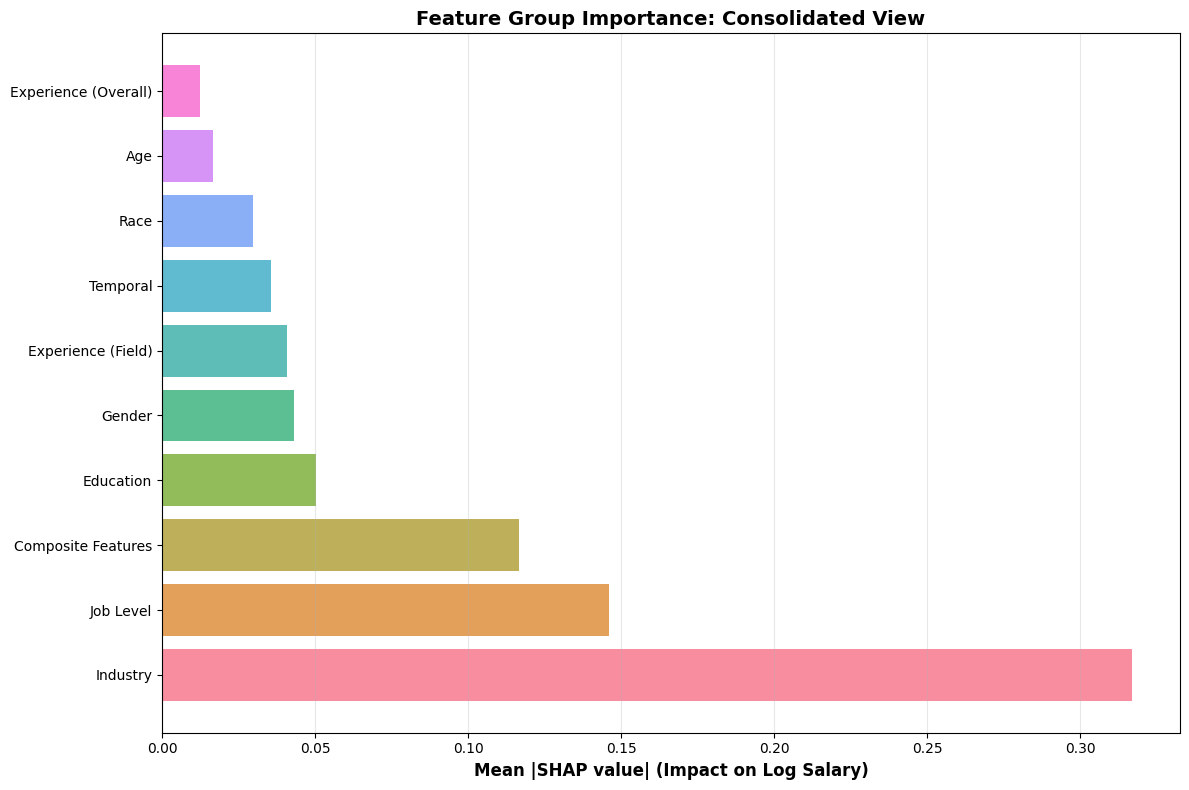

In [74]:
# Visualize
fig, ax = plt.subplots(figsize=(12, 8))

groups = consolidated_df['Feature Group'].to_list()
means = consolidated_df['Mean |SHAP|'].to_list()
stds = consolidated_df['Std |SHAP|'].to_list()

colors = sns.color_palette("husl", len(groups))
bars = ax.barh(groups, means, color=colors, alpha=0.8, capsize=5)

ax.set_xlabel('Mean |SHAP value| (Impact on Log Salary)', fontweight='bold', fontsize=12)
ax.set_title('Feature Group Importance: Consolidated View', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "shap_consolidated_importance.png", dpi=300)
plt.show()

From the bar above, we can see the main features influencing the model are industry, job level and education (excluding our composite features).

Let's take a deeper look into how these consolidated features break down.

## Local Explainability

In [100]:
top_groups = consolidated_df['Feature Group'].head(4).to_list()

for group_name in top_groups:
    group_indices = [idx for idx, g in feature_to_group.items() if g == group_name]
    
    if not group_indices:
        continue
    
    print(f"\n{group_name}")
    print("-" * 70)
    
    # Get feature names and their mean SHAP values
    feature_shaps = []
    for idx in group_indices:
        feature_name = feature_names[idx]
        mean_shap = np.abs(shap_values.values[:, idx]).mean()
        feature_shaps.append((feature_name, mean_shap))
    
    # Sort by importance
    feature_shaps.sort(key=lambda x: x[1], reverse=True)
    
    # Print top features in this group
    for i, (feat_name, shap_val) in enumerate(feature_shaps[:5], 1):
        # Clean feature name for display
        display_name = feat_name.replace('_', ' ').replace('ordinal', '').strip()
        print(f"  {i}. {display_name:40s}: {shap_val:.4f}")


Industry
----------------------------------------------------------------------
  1. industry Computing or Tech              : 0.1152
  2. industry Education (Higher Education)   : 0.0402
  3. industry Nonprofits                     : 0.0296
  4. industry Engineering or Manufacturing   : 0.0216
  5. industry Accounting Banking & Finance   : 0.0166

Job Level
----------------------------------------------------------------------
  1. job level other                         : 0.0632
  2. job level director                      : 0.0257
  3. job level c level                       : 0.0216
  4. job level senior                        : 0.0196
  5. job level vp                            : 0.0101

Composite Features
----------------------------------------------------------------------
  1. education experience interaction        : 0.1066
  2. experience ratio                        : 0.0077
  3. experience overall sq                   : 0.0023

Education
---------------------------------

In [116]:
# Calculate mean SHAP for each individual feature
feature_importance = []
for i, name in enumerate(feature_names):
    mean_shap = np.mean(np.abs(shap_values.values[:, i]))
    feature_importance.append({'Feature': name, 'Mean |SHAP|': mean_shap})

feature_importance_df = pl.DataFrame(feature_importance).sort('Mean |SHAP|', descending=True)

print("Top 15 Most Important Features:\n")
with pl.Config(tbl_rows=15):
    display(
    feature_importance_df.head(15)
    .with_columns(
        pl.concat_str(
            (pl.col("Mean |SHAP|") * 100).round(2),
            pl.lit("%")
        ).alias("Importance (%)")
    )
    .select(["Feature", "Importance (%)"])
)

Top 15 Most Important Features:



Feature,Importance (%)
str,str
"""industry_Computing or Tech""","""11.52%"""
"""education_experience_interacti…","""10.66%"""
"""job_level_other""","""6.32%"""
"""education_ordinal""","""5.03%"""
"""experience_field_years_ordinal""","""4.08%"""
"""industry_Education (Higher Edu…","""4.02%"""
"""gender_Man""","""3.29%"""
"""industry_Nonprofits""","""2.96%"""
"""job_level_director""","""2.57%"""


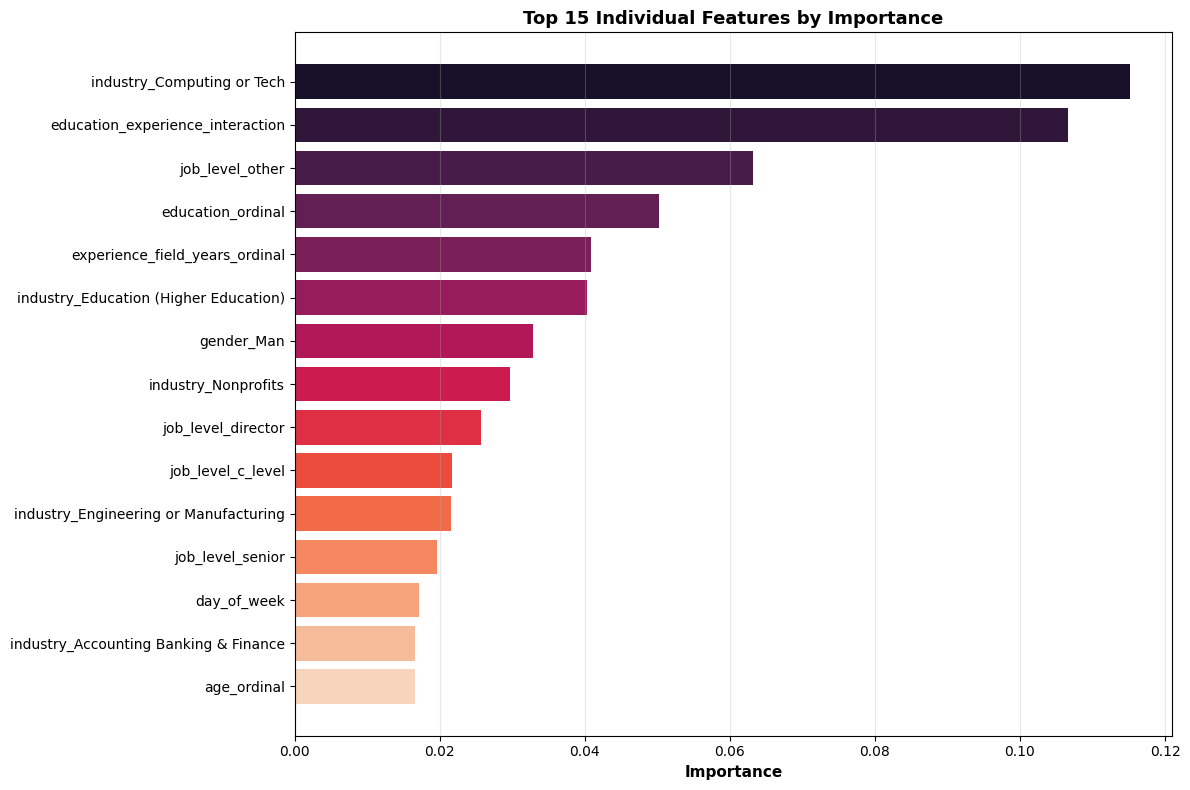

In [120]:
# Visualize top 15
fig, ax = plt.subplots(figsize=(12, 8))

top_15 = feature_importance_df.head(15)
ax.barh(range(len(top_15)), top_15['Mean |SHAP|'].to_list(), 
        color=sns.color_palette("rocket", len(top_15)))

ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['Feature'].to_list())
ax.set_xlabel('Importance', fontweight='bold', fontsize=11)
ax.set_title('Top 15 Individual Features by Importance', fontweight='bold', fontsize=13)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "explainability_top_features.png", dpi=300)
plt.show()

## Feature Dependence

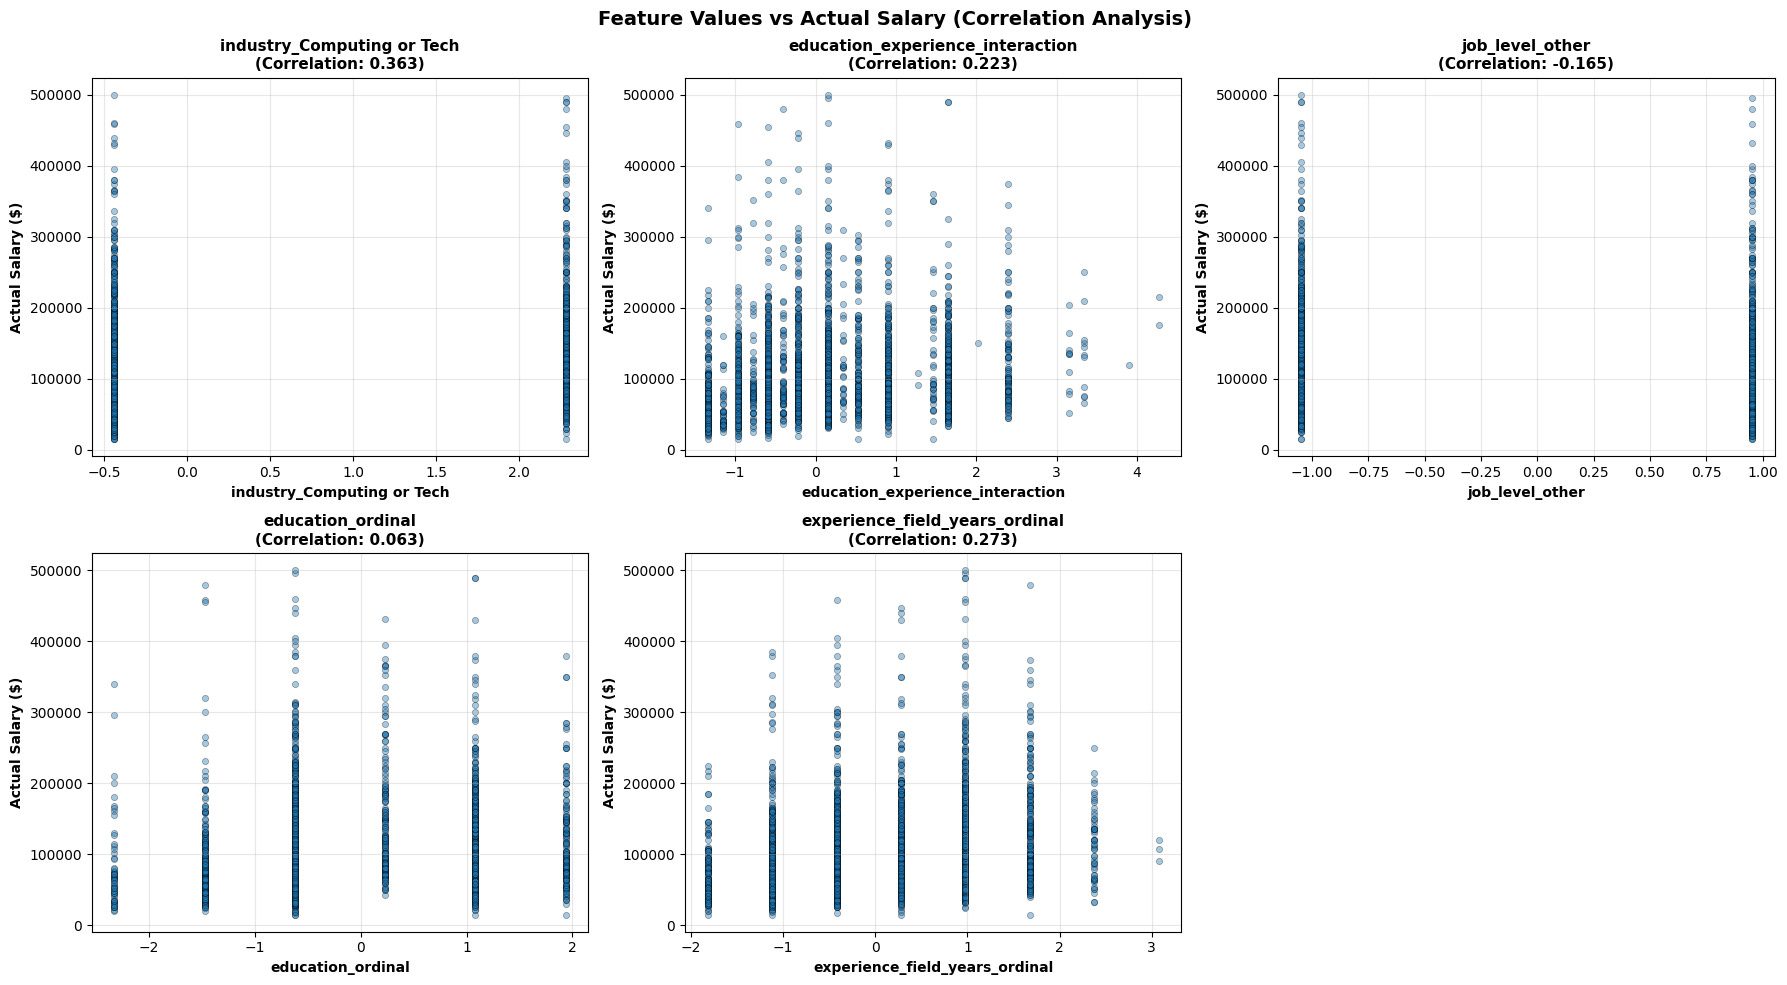

In [130]:
top_5_features = feature_importance_df.head(5)['Feature'].to_list()
top_5_indices = [feature_names.index(f) for f in top_5_features]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, idx, feat_name in zip(axes, top_5_indices, top_5_features):
    feat_vals = X_test.to_numpy()[:, idx]
    
    # Scatter plot
    ax.scatter(feat_vals, y_test_orig, alpha=0.4, s=20, edgecolors='black', linewidth=0.5)
    
    # Correlation coefficient
    corr = np.corrcoef(feat_vals, y_test_orig)[0, 1]
    
    ax.set_xlabel(f'{feat_name}', fontweight='bold', fontsize=10)
    ax.set_ylabel('Actual Salary ($)', fontweight='bold', fontsize=10)
    ax.set_title(f'{feat_name}\n(Correlation: {corr:.3f})', fontweight='bold', fontsize=11)
    ax.grid(alpha=0.3)
    ax.ticklabel_format(style='plain', axis='y')

axes[-1].remove()  # Remove extra subplot

plt.suptitle('Feature Values vs Actual Salary (Correlation Analysis)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "explainability_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

## Fairness Evaluation
Let's check the model for Gender Bias.

In [143]:
# Gender Analysis
predictions_all = np.expm1(best_model.predict(X_test.to_numpy()))

gender_man_idx = feature_names.index('gender_Man')
gender_woman_idx = feature_names.index('gender_Woman')
    
men_mask = X_test.to_numpy()[:, gender_man_idx] == 1
women_mask = X_test.to_numpy()[:, gender_woman_idx] == 1
    
men_actual = y_test_orig[men_mask]
men_pred = predictions_all[men_mask]
    
women_actual = y_test_orig[women_mask]
women_pred = predictions_all[women_mask]
    
men_mae = mean_absolute_error(men_actual, men_pred)
women_mae = mean_absolute_error(women_actual, women_pred)

men_bias = np.mean(men_pred - men_actual)
women_bias = np.mean(women_pred - women_actual)
    
print(f"\nMen (n={men_mask.sum()}):")
print(f"  Avg Actual Salary: ${np.mean(men_actual):>12,.0f}")
print(f"  Avg Predicted Salary: ${np.mean(men_pred):>10,.0f}")
print(f"  MAE: ${men_mae:>20,.0f}")
print(f"  Prediction Bias: ${men_bias:>16,.0f} ({'overestimated' if men_bias > 0 else 'underestimated'})")
    
print(f"\nWomen (n={women_mask.sum()}):")
print(f"  Avg Actual Salary: ${np.mean(women_actual):>12,.0f}")
print(f"  Avg Predicted Salary: ${np.mean(women_pred):>10,.0f}")
print(f"  MAE: ${women_mae:>20,.0f}")
print(f"  Prediction Bias: ${women_bias:>16,.0f} ({'overestimated' if women_bias > 0 else 'underestimated'})")
    
mae_diff = abs(men_mae - women_mae)
bias_diff = abs(men_bias - women_bias)
    
print(f"\nFairness Assessment:")
print(f"  MAE Difference: ${mae_diff:>17,.0f}")
print(f"  Bias Difference: ${bias_diff:>16,.0f}")

# Check if gender is a significant predictor
gender_indices = [gender_man_idx, gender_woman_idx]
gender_mean_shap = np.mean(np.abs(shap_values.values[:, gender_indices]))
all_mean_shap = np.mean(np.abs(shap_values.values))
gender_importance_ratio = gender_mean_shap / all_mean_shap

print(f"\n  Gender Feature Importance: {gender_importance_ratio*100:.1f}% of average")


Men (n=616):
  Avg Actual Salary: $     130,078
  Avg Predicted Salary: $   118,848
  MAE: $              41,043
  Prediction Bias: $         -11,230 (underestimated)

Women (n=2658):
  Avg Actual Salary: $      91,203
  Avg Predicted Salary: $    83,675
  MAE: $              27,199
  Prediction Bias: $          -7,529 (underestimated)

Fairness Assessment:
  MAE Difference: $           13,844
  Bias Difference: $           3,702

  Gender Feature Importance: 129.7% of average


A Bias Difference of \\$3,702 is not particular alarming given the average predicted salary is \\$83,675 and \\$118,848.

Moreoever, the gender feature importance being 129.7% indicates that gender is a stronger predictor than average features, i.e. the model has learnt the gender wage gap from historical data.

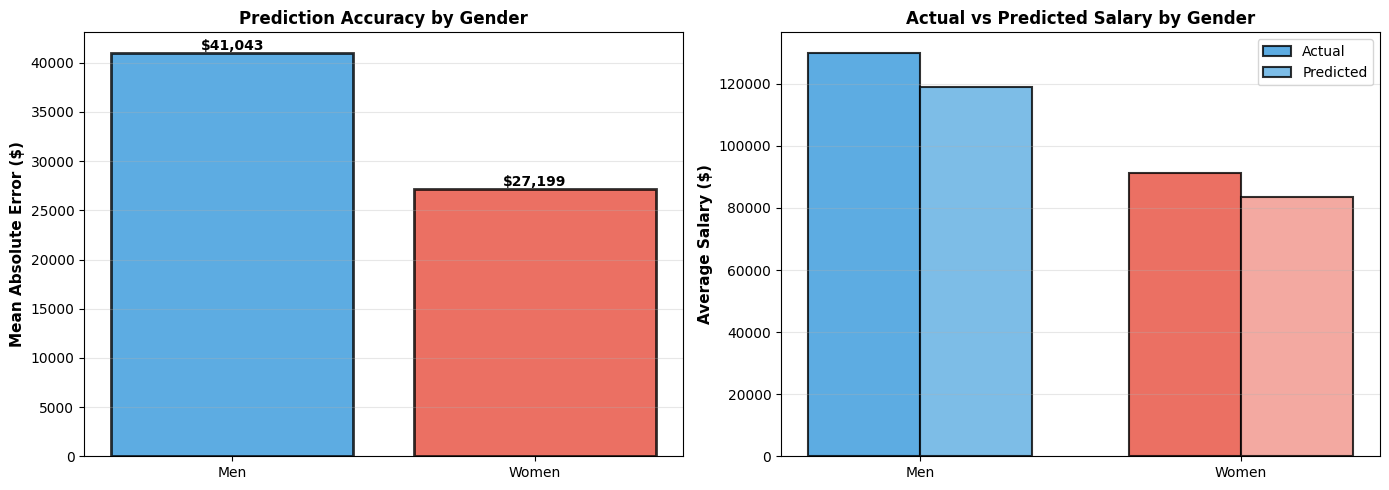

In [144]:
# Visualize fairness
if 'gender_Man' in feature_names and 'gender_Woman' in feature_names:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # MAE comparison
    genders = ['Men', 'Women']
    maes = [men_mae, women_mae]
    colors_gender = ['#3498db', '#e74c3c']
    
    bars = axes[0].bar(genders, maes, color=colors_gender, alpha=0.8, edgecolor='black', linewidth=2)
    axes[0].set_ylabel('Mean Absolute Error ($)', fontweight='bold', fontsize=11)
    axes[0].set_title('Prediction Accuracy by Gender', fontweight='bold', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, maes):
        axes[0].text(bar.get_x() + bar.get_width()/2, val, f'${val:,.0f}', 
                    ha='center', va='bottom', fontweight='bold')
    
    # Salary comparison
    x = np.arange(2)
    width = 0.35
    
    axes[1].bar(x - width/2, [np.mean(men_actual), np.mean(women_actual)], 
               width, label='Actual', color=['#3498db', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[1].bar(x + width/2, [np.mean(men_pred), np.mean(women_pred)], 
               width, label='Predicted', color=['#5dade2', '#f1948a'], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    axes[1].set_ylabel('Average Salary ($)', fontweight='bold', fontsize=11)
    axes[1].set_title('Actual vs Predicted Salary by Gender', fontweight='bold', fontsize=12)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(genders)
    axes[1].legend(fontsize=10)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Path(FIGURES_SAVE_PATH) / "explainability_fairness.png", dpi=300)
    plt.show()

## Summary
### Strongest Predictors
1. Industry (31.6%)
2. Job Level (14.6%)
3. Education * Experience (10.6%)

### Model Explainability
- Model Predictions are explained via SHAP analysis

### Fairness
- Model Predictions have a low bias for gender, while safely accounting for gender as a predictor.